In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import json

import os
from typing import List, Tuple, Union


from scipy.io import loadmat,savemat
import matplotlib.pyplot as plt



from statesim.analysis import plot_simulation_results as plot
from statesim.system import pendulum, coupled_msd
from statesim.configuration import GenerateConfig
from statesim.simulator import ContinuousSimulator
from statesim.model.statespace import Nonlinear

from crnn.configuration.experiment import load_configuration, ExperimentConfig, ExperimentTemplate
from crnn.models.model_io import get_model_from_config
from crnn.models.base import load_model
from crnn.additional_tests import InputOutputStabilityL2, retrieve_additional_test_class, AdditionalTestConfig, StabilityOfInitialState
from crnn.tracker.io import IoTracker
from crnn.utils import base as utils
from crnn.data_io import load_normalization

import torch
torch.set_default_dtype(torch.double)

from dataclasses import asdict



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load true system

In [3]:
# pendulum
# config_file_name = '/Users/jack/actuated_pendulum/data/nonlinear-initial_state-0_M-500_T-10/raw/config.json'
# coupled msd
config_file_name = '/Users/jack/coupled-msd/data/coupled-msd-routine/raw/config.json'
with open(config_file_name, 'r') as f:
    config = json.load(f)

config = GenerateConfig(**config)
noise_config = config.measurement_noise
N = int(config.T / config.step_size)

# sys = pendulum.ActuatedPendulum()
sys = coupled_msd.CoupledMsd()
model = Nonlinear(
    sys.state_dynamics,
    sys.output_function,
    sys.nx,
    sys.ny,
    sys.nu
)
dt = config.step_size

# load model

In [4]:

# data_file_name = '/Users/jack/cloud_privat/03_Promotion/_transfer/P-32-joint-lstm/seq/test_output-stability_l2-nonlinear-initial_state-0_M-500_T-10.mat'

# result_root_directory = '/Users/jack/cloud_privat/03_Promotion/_transfer/'
result_root_directory = '/Users/jack/coupled-msd/2024_11_21-cRnn'
# m_e_config_file_name = '/Users/jack/cloud_privat/03_Promotion/_transfer/actuated_pendulum.json'
m_e_config_file_name = '/Users/jack/coupled-msd/2024_11_21-cRnn/coupled-msd.json'

b, num_layer = 1,2
# m_e_name = 'P-32-joint-lstm'
m_e_names = {'MSD-32-joint-lstm', 'MSD-16-joint-tanh', 'MSD-16-joint-dzn', 'MSD-16-joint-dznGen'}

initializers, predictors = [], []
for m_e_name in m_e_names:
    e_m_config = None
    e_m_config = load_configuration(m_e_config_file_name)
    model_config = e_m_config.models[m_e_name]
    initializer, predictor = get_model_from_config(model_config)

    initializer, predictor = (
        load_model(
            model, 
            os.path.join(result_root_directory, m_e_name, utils.get_model_file_name(name, m_e_name))
        ) 
        for model, name in zip([initializer, predictor], ["initializer", "predictor"])
    )
    initializers.append(initializer)
    predictors.append(predictor)



# Evaluation


In [42]:
h = 500
test_config = AdditionalTestConfig(epochs=500, horizon=h, lr=0.01, sampling_type='optimize', scale=0.5)

## initial state

In [43]:
x0_ehats = []
for predictor in predictors:

    testX0 = StabilityOfInitialState(test_config, predictor, IoTracker())
    res_testX0 = testX0.test()
    x0 = [torch.tensor(x0_i) for x0_i in res_testX0.input_output[0].x0]
    h = 500
    d = torch.zeros(b,h,predictor.nd)
    e_hat, _ = predictor.forward(d,x0)
    x0_ehats.append(e_hat[0].detach().numpy())


0/500: xk norm: 0.97, e_hat norm 8.29
2/500: xk norm: 0.99, e_hat norm 8.54
81/500: xk norm: 0.99, e_hat norm 18.73
90/500: xk norm: 1.00, e_hat norm 19.22
149/500: xk norm: 1.00, e_hat norm 19.42
189/500: xk norm: 1.00, e_hat norm 19.65
334/500: xk norm: 1.01, e_hat norm 20.06
0/500: xk norm: 0.00, e_hat norm 2.24
1/500: xk norm: 0.00, e_hat norm 2.29
2/500: xk norm: 0.00, e_hat norm 2.34
3/500: xk norm: 0.00, e_hat norm 2.39
4/500: xk norm: 0.00, e_hat norm 2.44
5/500: xk norm: 0.00, e_hat norm 2.49
6/500: xk norm: 0.00, e_hat norm 2.55
7/500: xk norm: 0.00, e_hat norm 2.60
8/500: xk norm: 0.00, e_hat norm 2.66
9/500: xk norm: 0.00, e_hat norm 2.72
10/500: xk norm: 0.00, e_hat norm 2.78
11/500: xk norm: 0.00, e_hat norm 2.84
12/500: xk norm: 0.00, e_hat norm 2.90
13/500: xk norm: 0.00, e_hat norm 2.96
14/500: xk norm: 0.00, e_hat norm 3.03
15/500: xk norm: 0.00, e_hat norm 3.09
16/500: xk norm: 0.00, e_hat norm 3.16
17/500: xk norm: 0.00, e_hat norm 3.23
18/500: xk norm: 0.00, e_hat 

## Generate random initial conditions and simulate true system
Evaluate convergence property

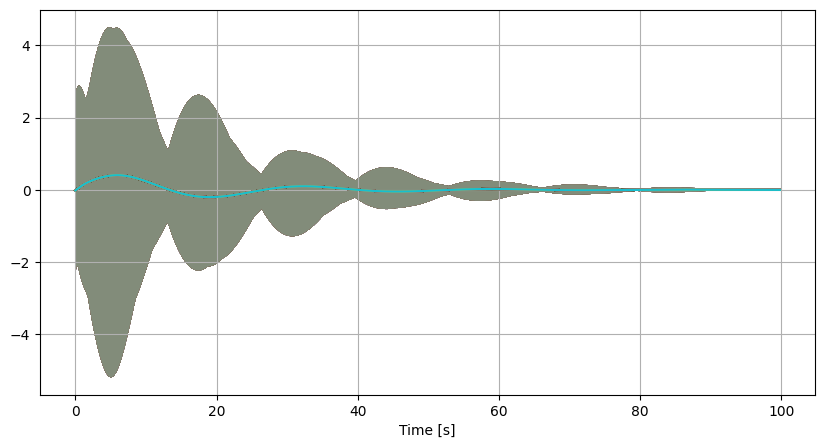

In [40]:
T = h*dt
sim = ContinuousSimulator(T=T, step_size=config.step_size)

es = []
for i in range(100):
    result = sim.simulate(
        model=model,
        initial_state=np.random.randn(sys.nx, 1),
        input=[d_k.reshape(sys.nu,1) for d_k in np.zeros((h, sys.nu))],
    )
    es.append(result.ys)

es_numpy = np.stack(es)
m = es_numpy.mean(axis=0)
std = es_numpy.std(axis=0)
mi = es_numpy.min(axis=0)
ma = es_numpy.max(axis=0)

t = np.linspace(0, (h-1)*dt, h)
fig, ax = plt.subplots(figsize=(10, 5))
for e in es:
    ax.fill_between(t, mi[:,0,0], ma[:,0,0], alpha=0.2)
    ax.plot(t, m[:,0])
ax.set_xlabel('Time [s]')
ax.grid()

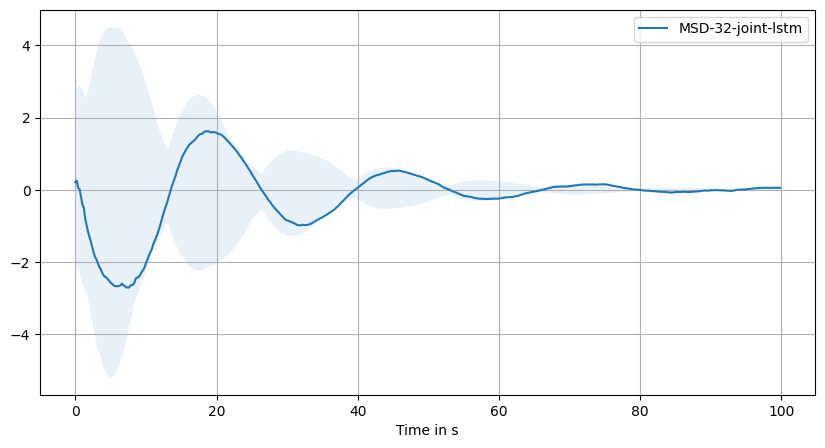

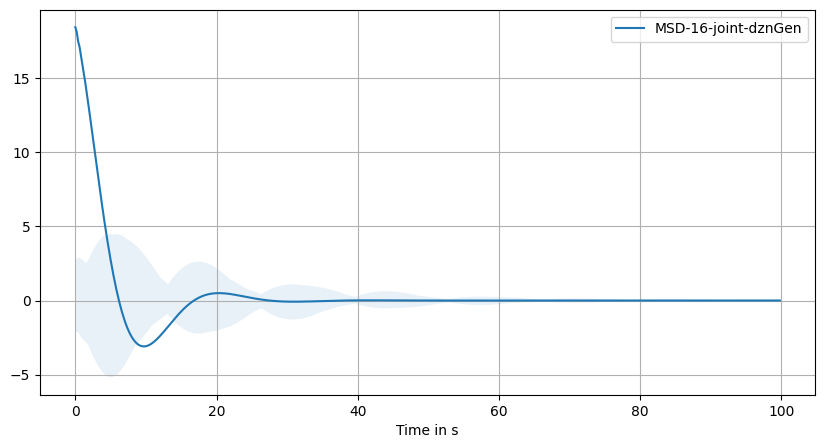

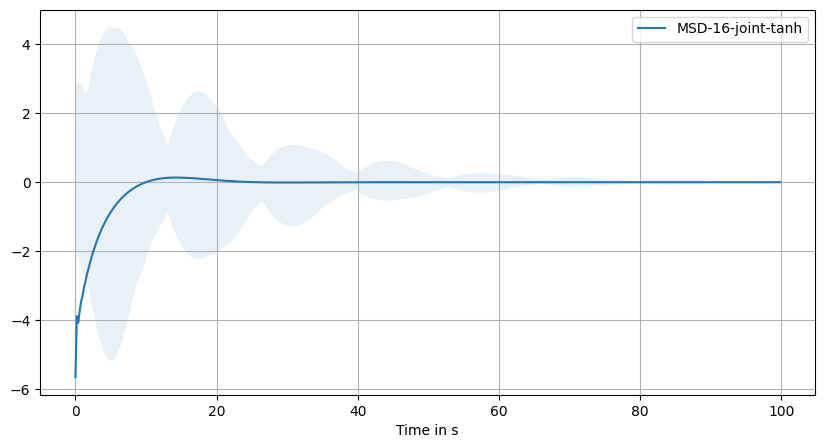

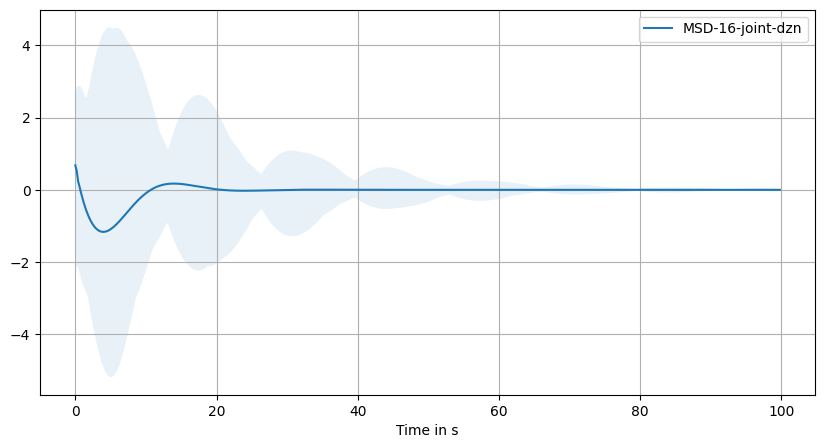

In [44]:

for name, e_hat in zip(m_e_names, x0_ehats):
    t = np.linspace(0, (h-1)*dt, h)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.fill_between(t, mi[:,0,0], ma[:,0,0], alpha=0.1)
    ax.plot(t, e_hat, label=name)
    # ax.plot(t, res_testX0.input_output[0].e_hat[0],'--', label='e_hat return')
    ax.set_xlabel('Time in s')
    ax.grid()
    ax.legend()
# torch.tensor(res_testX0.input_output[0].x0.reshape()).shape

## l2 stability

In [45]:
for predictor, name in zip(predictors, m_e_names):
    if 'lstm' not in name:
        continue
    normalization = load_normalization(os.path.join(result_root_directory,name))
    test = InputOutputStabilityL2(test_config,predictor, IoTracker())
    res = test.test()
    d = res.input_output[0].d

us = [d_k.reshape(predictor.nd, 1) for d_k in d[0]]
T = d.shape[1] * dt



0/500: ga: 0.38, norm e_hat: 4.25, norm d: 11.07
1/500: ga: 0.42, norm e_hat: 4.70, norm d: 11.05
2/500: ga: 0.45, norm e_hat: 5.01, norm d: 11.04
3/500: ga: 0.50, norm e_hat: 5.54, norm d: 11.03
4/500: ga: 0.53, norm e_hat: 5.89, norm d: 11.02
5/500: ga: 0.55, norm e_hat: 6.11, norm d: 11.01
6/500: ga: 0.61, norm e_hat: 6.71, norm d: 11.01
7/500: ga: 0.65, norm e_hat: 7.12, norm d: 11.01
8/500: ga: 0.69, norm e_hat: 7.57, norm d: 11.01
9/500: ga: 0.74, norm e_hat: 8.10, norm d: 11.02
10/500: ga: 0.76, norm e_hat: 8.32, norm d: 11.02
11/500: ga: 0.82, norm e_hat: 9.01, norm d: 11.03
12/500: ga: 0.84, norm e_hat: 9.25, norm d: 11.04
13/500: ga: 0.90, norm e_hat: 9.89, norm d: 11.05
14/500: ga: 0.95, norm e_hat: 10.50, norm d: 11.05
15/500: ga: 0.99, norm e_hat: 10.92, norm d: 11.06
16/500: ga: 1.04, norm e_hat: 11.47, norm d: 11.07
17/500: ga: 1.08, norm e_hat: 11.91, norm d: 11.07
18/500: ga: 1.12, norm e_hat: 12.39, norm d: 11.07
19/500: ga: 1.15, norm e_hat: 12.74, norm d: 11.08
20/5

In [46]:
l2_ehats = []
for predictor in predictors:
    e_hat, _ = predictor.forward(torch.tensor(d))
    e_hats = utils.denormalize(
        [e_hat.detach().numpy()], normalization.output.mean, normalization.output.std
    )
    l2_ehats.append(e_hats[0][0])


In [47]:
result = sim.simulate(
    model=model,
    initial_state=np.array(config.simulator.initial_state).reshape(
        config.system.nx, 1
    ),
    input=us,
)

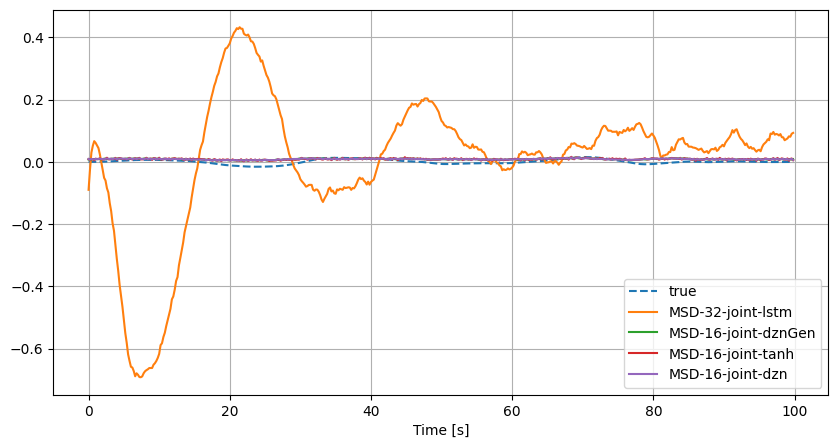

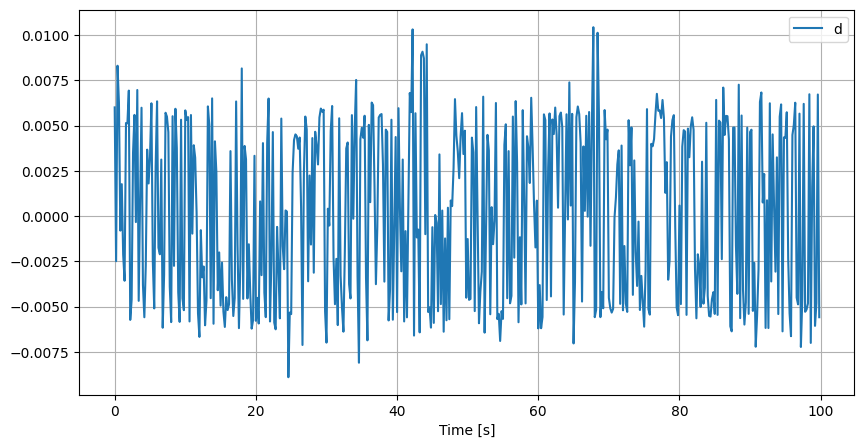

In [ ]:
import tikzplotlib
embedding_directory = os.path.join(result_root_directory, '_for_embedding')
os.makedirs(embedding_directory, exist_ok=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(result.t, np.vstack(result.ys),'--', label='true')

for name, e_hat in zip(m_e_names, l2_ehats):
    ax.plot(result.t, e_hat, label=name)
    
ax.set_xlabel('Time [s]')
ax.legend()
ax.grid()

tikzplotlib.save(os.path.join(embedding_directory, 'critical_l2_output.tex'))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(result.t, np.vstack(result.us), label='d')
ax.grid()
ax.legend()
ax.set_xlabel('Time [s]')

tikzplotlib.save(os.path.join(embedding_directory, 'critical_l2_input.tex'))